In [1]:
import torch
from torch import nn
from typing import List
from cv.utils.anchorbox import multibox_target, multibox_prior
from cv.tutorial.test_data import get_test_data

class Block(nn.Module):
    """Using base cnn layer."""
    def __init__(self, in_channel, o_channel):
        super().__init__()
        
        layers = []
        for _ in range(2):
            cnn = nn.Conv2d(in_channel, o_channel,kernel_size = 3,padding = 1)
            layers.append(cnn)
            layers.append(nn.BatchNorm2d(o_channel))
            layers.append(nn.ReLU())
            in_channel = o_channel
        layers.append(nn.MaxPool2d(2))

        self.blks = nn.Sequential(*layers)

    def forward(self, X):
        return self.blks(X)


class BaseNet(nn.Module):
    """Extract feature map."""
    def __init__(self):
        super().__init__()
        channels = [3, 16, 32, 64]

        blks = []
        for i in range(len(channels) - 1):
            blks.append(Block(channels[i], channels[i+1]))
        
        self.blks= nn.Sequential(*blks)

    def forward(self, X):
        return self.blks(X)


class Predictor(nn.Module):
    def __init__(self, num_classes, in_channels, num_anchors):
        super().__init__()
        # Add background class
        # Not change size
        self.num_classes, self.num_anchors=  num_classes, num_anchors
        
        self.classifier = nn.Conv2d(in_channels, num_anchors * (self.num_classes + 1), 3, padding = 1)
        self.pos_predictor = nn.Conv2d(in_channels, num_anchors * 4, 3, padding = 1)
    
    def forward(self, X):
        # X: (B, C, H, W)
        # classes : (B, A*(C+1), H, W)-> (B, H, W, A*(C+1))
        classes =  self.classifier(X).permute(0, 2, 3, 1)
        # offsets: (B, A*4, H, W)->(B, H, W, A*4)
        offsets = self.pos_predictor(X).permute(0, 2, 3, 1)

        return classes, offsets


class SSD(nn.Module):
    def __init__(self, num_class: int, sizes: List[float], ratios: List[float]):
        super().__init__()
        self.num_anchors = len(sizes[0]) + len(ratios[0]) - 1
        self.num_class= num_class
        self.in_channels = [64, 128, 128, 128, 128]

        self.layers = nn.ModuleList(self.blks(self.in_channels))
        self.predictors = nn.ModuleList([Predictor(num_class, c, self.num_anchors) 
                                        for c in self.in_channels])
        self.sizes = sizes
        self.ratios = ratios
        
    def blks(self, in_channels):
        blks = []
        
        blks.append(BaseNet())
        blks.append(Block(in_channels[0],in_channels[1]))
        blks.append(Block(in_channels[1],in_channels[2]))
        blks.append(Block(in_channels[2],in_channels[3]))
        blks.append(nn.AdaptiveMaxPool2d((1,1)))
        
        return blks

    def forward(self, X):
        # X: (B, C, H, W)
        anchor_res , class_res, offset_res = [],[],[]
        for i, m in enumerate(self.layers.children()):
            X = m(X)
            classes, offsets = self.predictors[i](X)
            anchors = multibox_prior(X, self.sizes[i], self.ratios[i])

            anchor_res.append(anchors)
            class_res.append(classes)
            offset_res.append(offsets)
        
        def concate(predicts):
            predicts = [torch.flatten(p, 1) for p in predicts]
            return torch.cat(predicts, 1)
        
        class_res= concate(class_res)
        class_res = class_res.reshape(class_res.shape[0], -1, self.num_class + 1)
        return torch.cat(anchor_res, 1), class_res, concate(offset_res)


class SSDLoss():
    def __init__(self):
        self.class_loss = nn.CrossEntropyLoss()
        self.offset_loss = nn.L1Loss()

    def __call__(self,classes_predict, offsets_predict, real_labels, real_offsets, offset_mask):
        cls_loss = self.class_loss(
                            classes_predict.reshape(-1, classes_predict.shape[-1]),
                            real_labels.reshape(-1))
        o_loss = self.offset_loss(offsets_predict * offset_mask,
                                    real_offsets*offset_mask)
        
        return cls_loss + o_loss

def metric(class_predict, offset_predict, labels, offsets, offset_mask):
    corrects = (class_predict.argmax(-1) == labels).sum()
    mae = (torch.abs(offset_predict - offsets)*offset_mask).sum()

    return corrects, labels.numel(), mae, offsets.numel()

def train(model, epochs, optimizer, criterion, trainloader, testloader, device):
    model.train()
    res = torch.zeros((4,))
    for epoch in range(epochs):
        for X,Y in trainloader:
            X, Y = X.float().to(device), Y.unsqueeze(1).to(device)
            anchors, classes, offsets = model(X)

            optimizer.zero_grad()
            real_offsets, offset_mask, real_labels = multibox_target(anchors, Y)
            l = criterion(classes, offsets, real_labels, real_offsets, offset_mask)
            l.backward()
            optimizer.step()

            metrics = metric(classes, offsets, real_labels, real_offsets, offset_mask)
            res = res + torch.tensor(metrics)

        cls_score, offset_score = evaluate(model, testloader, device)
        print(f"epoch {epoch+1}/{epochs} train score:{metrics[0]/metrics[1]:.2f},{metrics[2]/metrics[3]:.2f}"
                f" test score:{cls_score:.2f},{offset_score:.2f}")

def evaluate(model, dataloader, device):
    training = model.training
    model.eval()
    res = torch.zeros((4,))
    for X,Y in dataloader:
        with torch.no_grad():
            X, Y = X.float().to(device), Y.unsqueeze(1).to(device)
            anchors, classes, offsets = model(X)

            real_offsets, offset_mask, real_labels = multibox_target(anchors, Y)
            metrics = metric(classes, offsets, real_labels, real_offsets, offset_mask)
            res = res + torch.tensor(metrics)

    model.train(training)
    return res[0]/res[1], res[2]/res[3]

In [2]:

sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5

batch_size, epochs, device = 16, 10, torch.device("cuda")
model = SSD(1, sizes, ratios)
model.to(device)

criterion = SSDLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

train_loader, test_loader= get_test_data(batch_size)

train(model, epochs, optimizer, criterion, train_loader, test_loader, device)


/home/wushan/miniconda3/envs/torch/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch 1/10 train score:0.99,0.00 test score:1.00,0.00
epoch 2/10 train score:1.00,0.00 test score:1.00,0.00
epoch 3/10 train score:1.00,0.00 test score:1.00,0.00
epoch 4/10 train score:1.00,0.00 test score:1.00,0.00
epoch 5/10 train score:1.00,0.00 test score:1.00,0.00
epoch 6/10 train score:1.00,0.00 test score:1.00,0.00
epoch 7/10 train score:1.00,0.00 test score:1.00,0.00
epoch 8/10 train score:1.00,0.00 test score:1.00,0.00
epoch 9/10 train score:1.00,0.00 test score:1.00,0.00
epoch 10/10 train score:1.00,0.00 test score:1.00,0.00


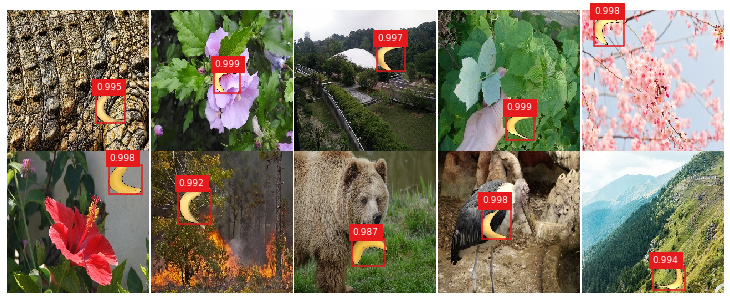

In [25]:
from cv.utils.anchorbox import multibox_detection
import torch.nn.functional as F
from img import add_patches, imgs_show
import matplotlib.pyplot as plt

def predict(X):
    model.eval()
    
    anchors, classes, offsets = model(X)
    classes = F.softmax(classes, dim = -1).permute(0,2,1)
    predicts = multibox_detection(classes, offsets, anchors)
    return predicts

for X,Y in test_loader:
    examples = X[:10]
    X = examples.float().to(device)
    res = predict(X)
    break

threshold = 0.9

h,w = examples.shape[-2:]
scale = torch.tensor((w,h,w,h))

axes = imgs_show(examples.permute(0,2,3,1),2)
for i, ax in enumerate(axes):
    boxes, names =[],[]
    for i in res[i]:
        if (i[0] <0):
            continue
        if (i[1]< threshold):
            continue
        boxes.append(i[-4:])
        names.append(str(round(i[1].item(),3)))

    add_patches(ax, torch.stack(boxes).cpu() * scale, names)